#### First part
Load from some MQTT dumped data files that have been created by running commands on the command line. 
We have 6 espurna plug sensors and one temperature sensor in the fridge.

* Check the sonoff on low loads.  The fridge is reading a 1W spike every 20 seconds; if this is cumulative then it can be evened out.  
* a no load gives zero readings, is it factored out?  put one after another.
* Check this against a good DC regulator with a resistor.  V=IR p=VI=V^2/R=  5V would need 25ohm resistor makes 0.2amps
* the idea of extending the qsegment backwards with its parameters to match points up there doesn't work

* Next to try categorize short (more than 3) value segments to characterize their ranges and use them to project into the intermediate value

* then group together noise elements that contain spikes (like the fridge)

* Finally generate a series of points representing the sizes of these intervals by height and see if this is a smoother value to characterize the PWM from some kind of chaotic bouncing in this histeresis

* given a sequence, what cut minimizes the sum of squares to the two sides

In [291]:
import pandas

# mosquitto_sub -v -h mqtt.local -t "+/desc" > powerdumpnames.txt
espnames = {}
for l in open("../sampledata/powerdumpnames.txt").readlines():
    p, n = l.split("/", 1)
    espnames[p] = n[4:].strip()
print(espnames)

# mosquitto_sub -v -h mqtt.local -t "+/power" | ts %.s > powerdump.txt
k = pandas.read_csv("../sampledata/powerdump.txt", delimiter=" ", names=["t", "dev", "pow"])
tmin, tmax = k.iloc[0].t, k.iloc[-1].t
k.t = k.t - tmin
k.head()

pows = [ ]
pownames = [ ]
for p in espnames:
    x = k[k.dev == p+"/power"]
    pownames.append(espnames[p])
    x = x.set_index("t")
    x.index.name = None
    pows.append(x["pow"])

print(len(k))

# temp measuring file
k = pandas.read_csv("../sampledata/ftempdump.txt", delimiter=" ", names=["t", "dev", "pow"])
k.t = k.t - tmin
ta = k[k.dev == "whitesp/tempambient"]
ta = ta.set_index("t")
ta.index.name = None
ta = pandas.to_numeric(ta["pow"])
tir = k[k.dev == "whitesp/tempir"]
tir = tir.set_index("t")
tir.index.name = None
tir = pandas.to_numeric(tir["pow"])


{'ESPURNA-8E30FD': 'Sophia Laser Cutter', 'ESPURNA-8E010B': 'VR computer', 'ESPURNA-8DFE16': 'Ultimaker Adam', 'ESPURNA-6821B6': 'Fridge', 'ESPURNA-8DF40E': 'Coffee Pot', 'ESPURNA-5483B8': 'CNC Machine', 'ESPURNA-547CD9': 'Ultimaker Felicity'}
124762


#### Second part
Once data is loaded, provide a time range widget for plotting the time series 

In [292]:
from ipywidgets import widgets
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib

    
timerange = widgets.FloatRangeSlider(value=(0, tmax-tmin), min=0, max=tmax-tmin, continuous_update=False)
timerange.layout.width = "600px"
devplot = widgets.Dropdown(options=pownames+["all"], value='all', continuous_update=False)
ui = widgets.HBox([timerange, devplot])

g = None
def plotfigure(timerange, devsel):
    global g
    plt.figure(figsize=(11,6))
    
    if devsel in pownames:
        ii = [pownames.index(devsel)]
    else:
        ii = list(range(len(pownames)))
        
    kwhtotal = 0
    for i in ii:
        s = pows[i].loc[timerange[0]:timerange[1]]
        plt.plot(s, label=pownames[i], lw=1)
        kwhtotal += sum((s.index.to_series().diff()*s).iloc[1:])/3600/1000
        g = s
        
    if devsel == "Fridge":
        s = ta.loc[timerange[0]:timerange[1]]
        plt.plot(s*50, label="temp", lw=1)
        
    plt.title("KWh=%.3f" % kwhtotal)
    plt.legend()
    plt.show()
    
    
params = {'timerange': timerange, "devsel":devplot }
outputfigure = widgets.interactive_output(plotfigure, params)
outputfigure.layout.height = '400px'
display(ui, outputfigure);



Output(layout=Layout(height='400px'))

In [294]:
vs = g.values
min(vs), max(vs), len(vs)

(0, 1279, 17959)

In [315]:
vs = ig.values
# single case one from vs
timerange = widgets.IntRangeSlider(value=(0, len(vs)), min=0, max=len(vs), continuous_update=False)
timerange.layout.width = "600px"
ui = widgets.HBox([timerange])

def plotfigure(timerange):
    plt.figure(figsize=(11,6))
    
    s = vs[timerange[0]:timerange[1]]
    plt.plot(s, lw=1)
    if len(s) < 1000:
        plt.scatter(range(len(s)), s)
    plt.show()
    
params = {'timerange': timerange }
outputfigure = widgets.interactive_output(plotfigure, params)
outputfigure.layout.height = '400px'
display(ui, outputfigure);


Output(layout=Layout(height='400px'))

In [316]:
from continuumseq import makecontinuumsegments
cseqs = makecontinuumsegments(vs)


(61381, 1, 105, [53.0])

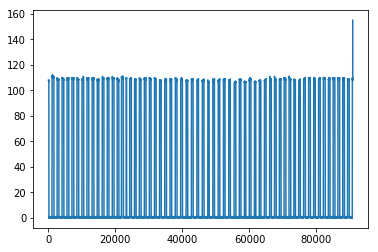

In [317]:
flatsections = numpy.concatenate([cseq.cvs[int(cseq.xc):]  for cseq in cseqs  if cseq.leng >= 10]) # getflatcvs
len(flatsections)
plt.plot(flatsections)

s = flatsections.copy()
s.sort()
def findicut(s):
    sqsumcutforward = (s[:-1]**2).cumsum() - s[:-1].cumsum()**2/numpy.arange(1, len(s))
    sqsumcutbackward = ((s[:0:-1]**2).cumsum() - s[:0:-1].cumsum()**2/numpy.arange(1, len(s)))[::-1]

    #Dsqsumcutforward = numpy.array([ s[:i].var()*i  for i in range(1, len(s)) ])
    #Dsqsumcutbackward = numpy.array([ s[i:].var()*(len(s)-i)  for i in range(1, len(s)) ])

    icut, var = min(enumerate(sqsumcutforward+sqsumcutbackward), key=lambda X:X[1])
    cutvalue = (s[icut] + s[icut+1])/2
    return icut

icut = findicut(s)
cutval = [ (s[icut]+s[icut+1])/2 ]
icut, s[icut], s[icut+1], cutval


In [ ]:
# Use the icut to categorize the cseqs into different types

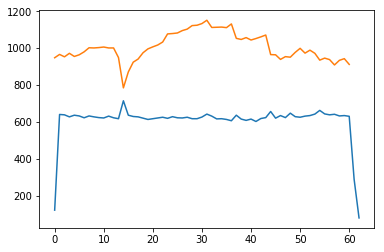

In [319]:
a = [ cseq.leng  for cseq in cseqs if cseq.leng>10 and cseq.ya > 60]
b = [ cseq.leng  for cseq in cseqs if cseq.leng>10 and cseq.ya < 60]
plt.plot(a)
plt.plot(b)


In [145]:
s = vs.copy()
s.sort()
plt.plot(s)
s.var()*len(s)

#s = numpy.array([0]*10 + [1]*30)
def findicut(s):
    vlo = numpy.array([ s[:i].var()*i  for i in range(1, len(s)-1) ])
    vhi = numpy.array([ s[i:].var()*(len(s)-i)  for i in range(1, len(s)-1) ])
    icut = min(enumerate(vlo+vhi), key=lambda X:X[1])[0] + 1
    cutvalue = (s[icut-1] + s[icut])/2
    return icut

icutstack = [ (0,s) ]
while icutstack:
    depth, s = icutstack.pop()
    plt.scatter([d], [s.mean()])
    if depth <= 5:
        
    


(1605, 200980.06491488873)

#### Third part
Given a time series, can we categorize the different states?


In [69]:
print(len(vs), len(cseqs))

1180 96


In [308]:
import influxdb
client = influxdb.DataFrameClient("10.0.30.194", 8086, "root", "root", "balena-sense")
#client.query("select * from power limit 100")
#k = client.query("select value from power where location='ESPURNA-8E010B' limit 10")
#k["power"]  # is a dataframe
k = client.query("select * from fridgepower order by time desc limit 10")
ig = k["fridgepower"].value  # the series

# nodered flow
# [{"id":"11d5face.42c1bd","type":"influxdb out","z":"d84acda1.662b58","influxdb":"a32c0730.b69478","name":"","measurement":"","precision":"","retentionPolicy":"","x":830,"y":380,"wires":[]},{"id":"4a45ae2e.860a1","type":"change","z":"d84acda1.662b58","name":"","rules":[{"t":"set","p":"payload","pt":"msg","to":"[\t   {\t       'value': $parseInteger(msg.payload, '0')\t   }\t]","tot":"jsonata"},{"t":"set","p":"measurement","pt":"msg","to":"fridgepower","tot":"str"}],"action":"","property":"","from":"","to":"","reg":false,"x":560,"y":320,"wires":[["94c7112e.d7e12","11d5face.42c1bd"]]},{"id":"3d344cf3.84457c","type":"mqtt in","z":"d84acda1.662b58","name":"Fridge power","topic":"ESPURNA-6821B6/power","qos":"2","datatype":"auto","broker":"9ed0b1d3.51a41","x":270,"y":320,"wires":[["4a45ae2e.860a1"]]},{"id":"a32c0730.b69478","type":"influxdb","z":"","hostname":"influxdb","port":"8086","protocol":"http","database":"balena-sense","name":"InfluxDB Balena-Sense","usetls":false,"tls":""},{"id":"9ed0b1d3.51a41","type":"mqtt-broker","z":"","name":"mosquitto","broker":"mosquitto","port":"1883","clientid":"","usetls":false,"compatmode":true,"keepalive":"60","cleansession":true,"birthTopic":"","birthQos":"0","birthPayload":"","closeTopic":"","closeQos":"0","closePayload":"","willTopic":"","willQos":"0","willPayload":""}]


In [314]:
k = client.query("select * from fridgepower order by time desc limit 100000")
ig = k["fridgepower"].value  # the series
ig.index[-1] - ig.index[0]

Timedelta('1 days 03:49:14.090415')

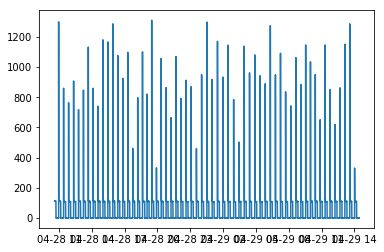

In [165]:
from ipywidgets import widgets
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
plt.plot(s)

In [187]:
# cseqs[50].xc, cseqs[50].leng


(119.51094670649718, 637)

KeyboardInterrupt: 

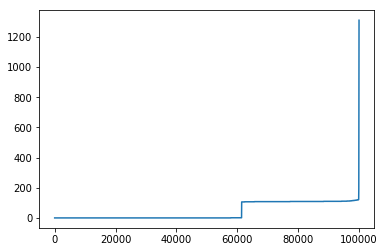

In [188]:
# Look for cuts that minimize the std values and see if it can get the 3 components
s = vs.copy()
s.sort()
#plt.plot(s)
s.var()*len(s)

#s = numpy.array([0]*10 + [1]*30)
vlo = numpy.array([ s[:i].var()*i  for i in range(1, len(s)-1) ])
vhi = numpy.array([ s[i:].var()*(len(s)-i)  for i in range(1, len(s)-1) ])
icut = min(enumerate(vlo+vhi), key=lambda X:X[1])[0] + 1
cutvalue = (s[icut-1] + s[icut])/2
icut, s[icut-1], s[icut]


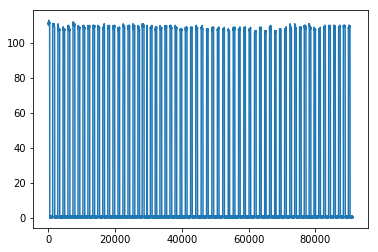

In [290]:

flatsections = numpy.concatenate([cseq.cvs[int(cseq.xc):]  for cseq in cseqs  if cseq.leng >= 10]) # getflatcvs
len(flatsections)
plt.plot(flatsections)
#plt.plot(vs)


In [262]:
s = vs.copy()
#s = numpy.array([1,2,3])
#s = numpy.random.random_sample(100)
s.sort()

def findicut(s):
    sqsumcutforward = (s[:-1]**2).cumsum() - s[:-1].cumsum()**2/numpy.arange(1, len(s))
    sqsumcutbackward = ((s[:0:-1]**2).cumsum() - s[:0:-1].cumsum()**2/numpy.arange(1, len(s)))[::-1]

    #Dsqsumcutforward = numpy.array([ s[:i].var()*i  for i in range(1, len(s)) ])
    #Dsqsumcutbackward = numpy.array([ s[i:].var()*(len(s)-i)  for i in range(1, len(s)) ])

    icut, var = min(enumerate(sqsumcutforward+sqsumcutbackward), key=lambda X:X[1])
    cutvalue = (s[icut] + s[icut+1])/2
    icut, s[icut], s[icut+1], var
    return icut


In [275]:
icuts = [ ]
depths = [ ]
maxdepth = 3
def icutrecurse(s, depth):
    if s.std() < 6:
        return
    if len(s) > 2:
        icut = findicut(s)
        print(s.var(), s[:icut+1].var(), s[icut+1:].var())
        icuts.append((s[icut] + s[icut+1])/2)
        depths.append(depth)
        if depth < maxdepth:
            icutrecurse(s[:icut+1], depth+1)
            icutrecurse(s[icut+1:], depth+1)
icutrecurse(s, 0)          

3398.7182113199 0.059652290746250496 1266.1859727162737
1266.1859727162737 28.14278434960644 43193.487024221446
43193.487024221446 15420.567665289256 7424.12326388889
15420.567665289256 3639.395555555556 3393.200951248514
7424.12326388889 1858.7777777777778 134.1388888888889


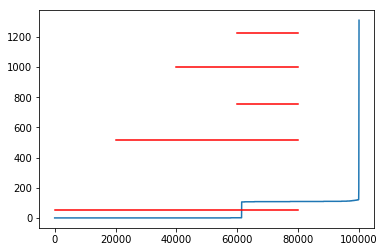

In [276]:
plt.plot(s)
for i in range(len(icuts)):
    plt.plot([depths[i]*20000, (maxdepth+1)*20000], [icuts[i], icuts[i]], color="red")


In [279]:
numpy.concatenate()

In [243]:
sqsumcutbackward = (s[:0:-1]**2).cumsum() - s[:0:-1].cumsum()**2/numpy.arange(1, len(s))
sqsumcutbackward = sqsumcutbackward[::-1]
sqsumcutbackward, Dsqsumcutbackward,sqsumcutbackward- Dsqsumcutbackward

(array([9.97812641e-01, 7.62843406e-01, 5.80242994e-01, 3.90788832e-01,
        1.59117450e-01, 8.72264082e-02, 3.16019763e-02, 7.69595741e-05,
        0.00000000e+00]),
 array([9.97812641e-01, 7.62843406e-01, 5.80242994e-01, 3.90788832e-01,
        1.59117450e-01, 8.72264082e-02, 3.16019763e-02, 7.69595741e-05,
        0.00000000e+00]),
 array([-2.22044605e-16, -4.44089210e-16,  0.00000000e+00,  5.55111512e-16,
         1.11022302e-16, -6.93889390e-17, -3.40005801e-16, -2.43376283e-16,
         0.00000000e+00]))

In [ ]:
s

In [214]:
s = numpy.array([0]*799 + [1]*700 + [2]*800)
vlo = numpy.array([ s[:i].var()*i  for i in range(1, len(s)-1) ])
vhi = numpy.array([ s[i:].var()*(len(s)-i)  for i in range(1, len(s)-1) ])
icut = min(enumerate(vlo+vhi), key=lambda X:X[1])[0] + 1
cutvalue = (s[icut-1] + s[icut])/2
icut, s[icut-1], s[icut]


(1499, 1, 2)

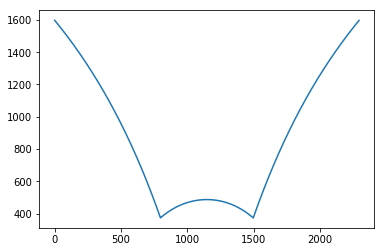

In [215]:
plt.plot(vlo+vhi)